# EDA on Experimental Data

In [2]:
import numpy as np
import json
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt

In [3]:
# Load data and define parameters
fname = "data/DS_10283_2901/fig2_stress_type_expts.json"
transcription_factors = ["mig1", "mig2", "msn2", "msn4", "dot6", "sfp1", "maf1", "tod6", "hog1", "yap1"]
stress = "gluc"
transcription_factor="mig1"
with open(fname, "r") as f:
    expts = json.load(f)

# data = np.array(expts[transcription_factor][stress]["GFP"]["nucLoc"]).astype("float")
data = np.array(expts[transcription_factor][stress]["GFP"]["median"]).astype("float")
t = np.array(expts[transcription_factor][stress]["general"]["times"]).astype("float")

## Visualise each TF one by one

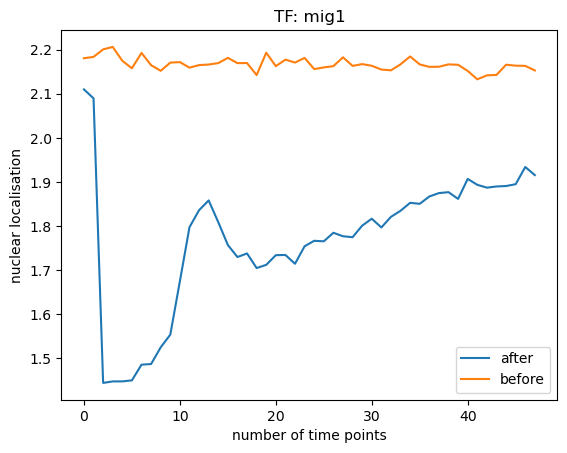

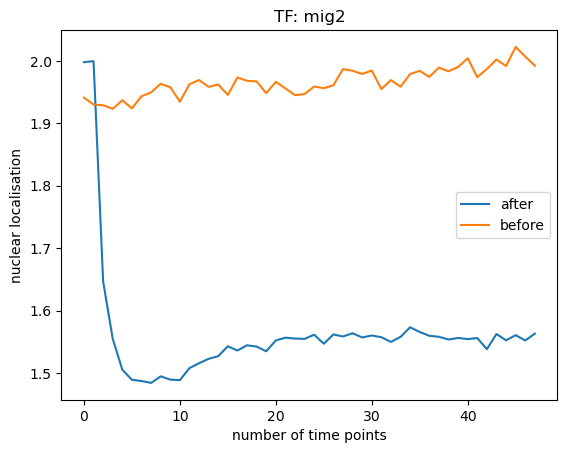

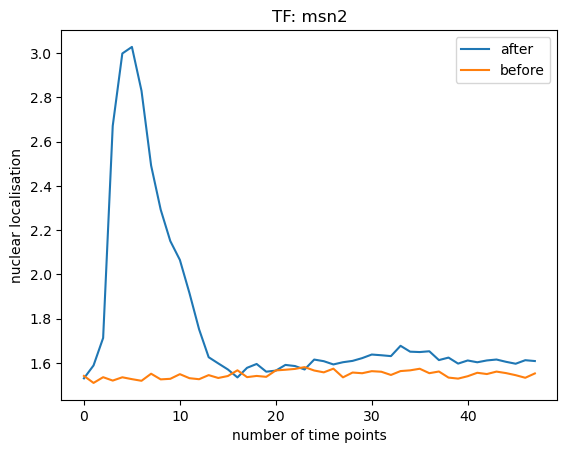

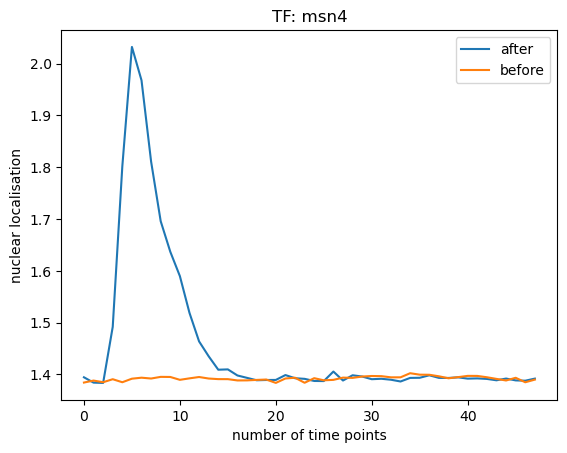

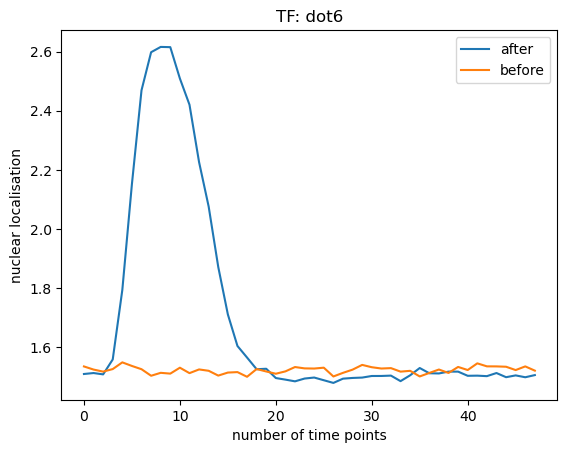

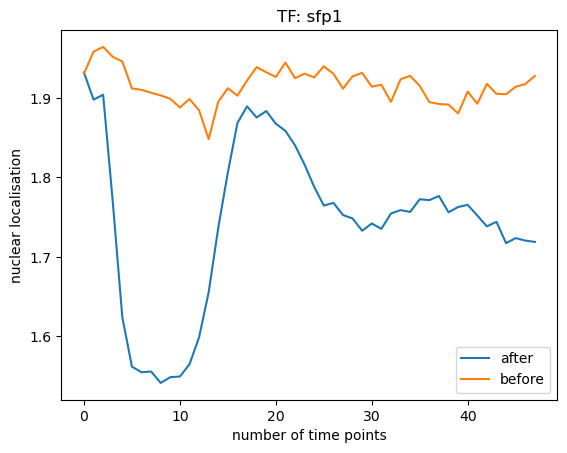

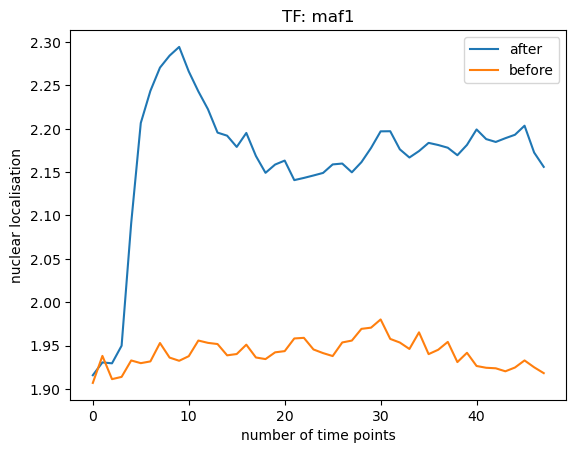

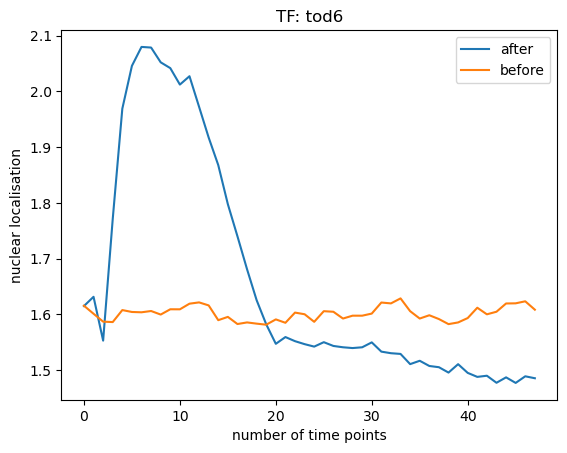

KeyboardInterrupt: 

In [3]:

# Load data and define parameters
fname = "data/DS_10283_2901/fig2_stress_type_expts.json"
transcription_factors = ["mig1", "mig2", "msn2", "msn4", "dot6", "sfp1", "maf1", "tod6", "hog1", "yap1"]
stress = "gluc"

with open(fname, "r") as f:
    expts = json.load(f)

# stress condition data
stress_data_all = []
# normal condition data
normal_data_all = []
max_len = 0

# Prepare training data for an example transcription factor
for transcription_factor in transcription_factors:
    data = np.array(expts[transcription_factor][stress]["GFP"]["nucLoc"]).astype("float")
    t = np.array(expts[transcription_factor][stress]["general"]["times"]).astype("float")
    normal_data = data[:, t[0, :] < 0]
    stress_data = data[:, t[0, :] >= 0]
    minlen = np.min([normal_data.shape[1], stress_data.shape[1]])
    normal_data = normal_data[:, -minlen:]
    stress_data = stress_data[:, :minlen:]

    # Fill NaN using IterativeImputer
    imp_mean = IterativeImputer(random_state=0)
    stress_data = imp_mean.fit_transform(stress_data)
    normal_data = imp_mean.fit_transform(normal_data)

    stress_data_all.append(stress_data)
    normal_data_all.append(normal_data)

    # plot the data
    plt.figure()
    plt.plot(np.mean(stress_data, axis=0), label="after")
    plt.plot(np.mean(normal_data, axis=0), label="before")
    plt.xlabel("number of time points")
    plt.ylabel("nuclear localisation")
    plt.title(f"TF: {transcription_factor}")
    plt.legend()
    plt.show(block=False)

    max_len = max(max_len, stress_data.shape[0], normal_data.shape[0])

# Pad arrays to the same length
stress_data_all = [np.pad(data, ((0, max_len - data.shape[0]), (0, 0)), 'constant') for data in stress_data_all]
normal_data_all = [np.pad(data, ((0, max_len - data.shape[0]), (0, 0)), 'constant') for data in normal_data_all]

stress_data_all = np.concatenate(stress_data_all, axis=1)
normal_data_all = np.concatenate(normal_data_all, axis=1)

## Mean, Variance, Autocorrelation

/home/ianyang/stochastic_simulations/src/stats/autocorrelation.py:87: RuntimeWarning: Mean of empty slice
  pos_corr[:, r] = np.nanmean(prods, axis=0)
/home/ianyang/stochastic_simulations/src/stats/autocorrelation.py:93: RuntimeWarning: Mean of empty slice
  neg_corr[:, r] = np.nanmean(prods, axis=0)


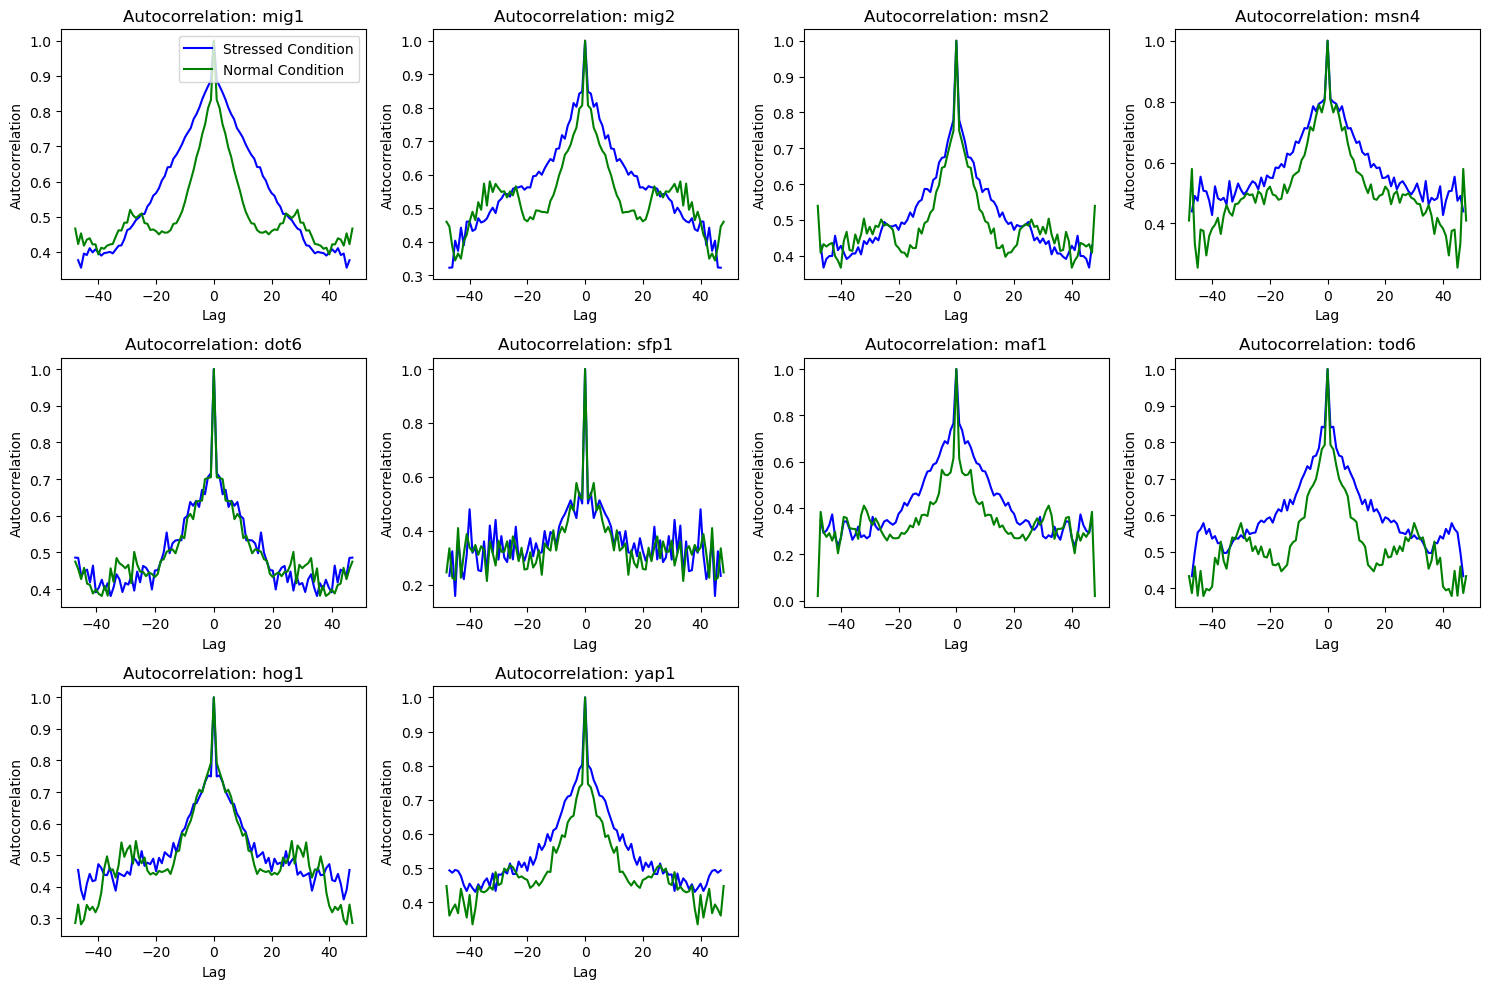

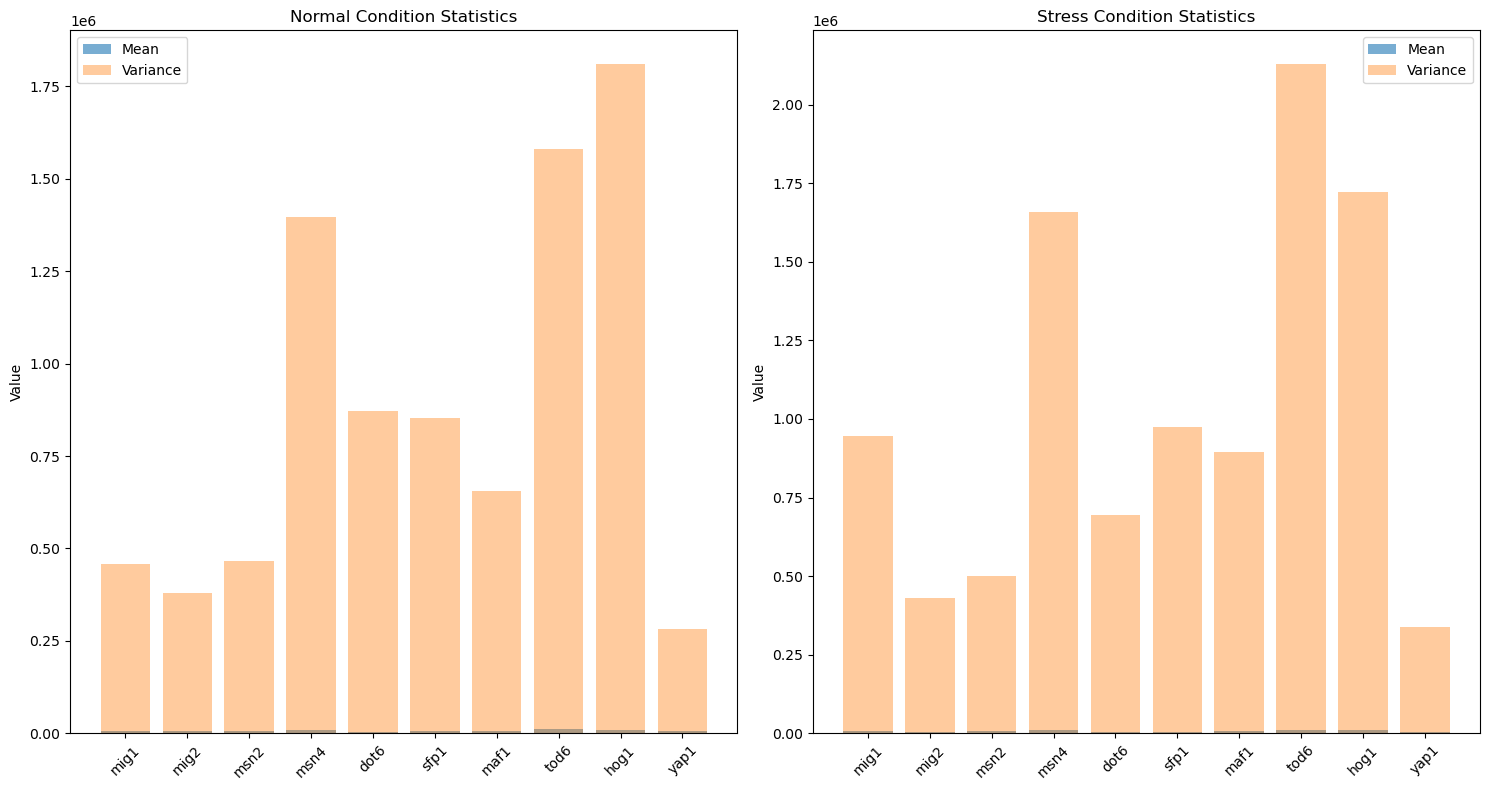

In [4]:

from stats.autocorrelation import autocrosscorr # for autocorrelation
from visualisation.plots import plot_autocorr # for plotting autocorrelation
import matplotlib.pyplot as plt
import numpy as np

# Create figure for all TFs summary
plt.figure(figsize=(15, 10))

# Dictionary to store statistics for all transcription factors
stats_summary = {}

for i, transcription_factor in enumerate(transcription_factors):
    # Extract data for this transcription factor
    data = np.array(expts[transcription_factor][stress]["GFP"]["median"]).astype("float")
    t = np.array(expts[transcription_factor][stress]["general"]["times"]).astype("float")
    
    # Split into normal and stress conditions
    normal_data = data[:, t[0, :] < 0]
    stress_data = data[:, t[0, :] >= 0]
    
    # Calculate statistics 
    normal_mean = np.nanmean(normal_data)
    normal_variance = np.nanvar(normal_data)
    stress_mean = np.nanmean(stress_data)
    stress_variance = np.nanvar(stress_data)
    
    # Store statistics in summary dictionary
    stats_summary[transcription_factor] = {
        "normal": {"mean": normal_mean, "variance": normal_variance},
        "stress": {"mean": stress_mean, "variance": stress_variance}
    }
        
    # Compute autocorrelation
    stress_autocorr, lags_stress = autocrosscorr(stress_data)
    normal_autocorr, lags_normal = autocrosscorr(normal_data)

    # Average autocorrelation across cells
    avg_normal_autocorr = np.nanmean(normal_autocorr, axis=0)
    avg_stress_autocorr = np.nanmean(stress_autocorr, axis=0)
    
    # Plot autocorrelation for this TF
    plt.subplot(3, 4, i+1)
    # max_lag = min(50, len(avg_normal_autocorr)-1, len(avg_stress_autocorr)-1)
    plt.plot(lags_stress, np.nanmean(stress_autocorr, axis=0), color='blue', label='Stressed Condition')
    plt.plot(lags_normal, np.nanmean(normal_autocorr, axis=0), color='green', label='Normal Condition')
    plt.title(f"Autocorrelation: {transcription_factor}")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    if i == 0:  # Only add legend to the first subplot
        plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
plt.figure(figsize=(15, 8))
for i, condition in enumerate(["normal", "stress"]):
    plt.subplot(1, 2, i+1)
    means = [stats_summary[tf][condition]["mean"] for tf in transcription_factors]
    variances = [stats_summary[tf][condition]["variance"] for tf in transcription_factors]
    
    plt.bar(range(len(transcription_factors)), means, alpha=0.6, label="Mean")
    plt.bar(range(len(transcription_factors)), variances, alpha=0.4, label="Variance")
    
    plt.xticks(range(len(transcription_factors)), transcription_factors, rotation=45)
    plt.title(f"{condition.capitalize()} Condition Statistics")
    plt.legend()
    plt.ylabel("Value")

plt.tight_layout()
plt.show()

Mean Statistics for Each Transcription Factor:


,Normal Mean,Stress Mean,Mean Change
mig1,6255.870856,6762.065466,506.19461
mig2,5890.463458,5653.432919,-237.030539
msn2,6631.029101,6382.855104,-248.173997
msn4,9444.011502,9367.374948,-76.636553
dot6,4754.599892,4290.099235,-464.500656
sfp1,5681.309355,5800.257384,118.948029
maf1,6602.421193,7354.459448,752.038254
tod6,11330.986781,11931.70565,600.718869
hog1,9936.027121,10375.051371,439.024249
yap1,5489.339915,5578.864922,89.525008



Variance Statistics for Each Transcription Factor:


,Normal Variance,Stress Variance,Variance Change
mig1,122472.388859,236661.745324,114189.356465
mig2,88608.813021,97593.026879,8984.213858
msn2,126200.730165,170064.082447,43863.352282
msn4,301457.717025,374678.661426,73220.9444
dot6,455220.689541,368667.539354,-86553.150187
sfp1,661833.886083,708697.038873,46863.15279
maf1,349312.908141,477430.132001,128117.22386
tod6,449848.915853,559339.8275,109490.911648
hog1,417702.96294,467330.212149,49627.249209
yap1,84191.013193,73562.470435,-10628.542759


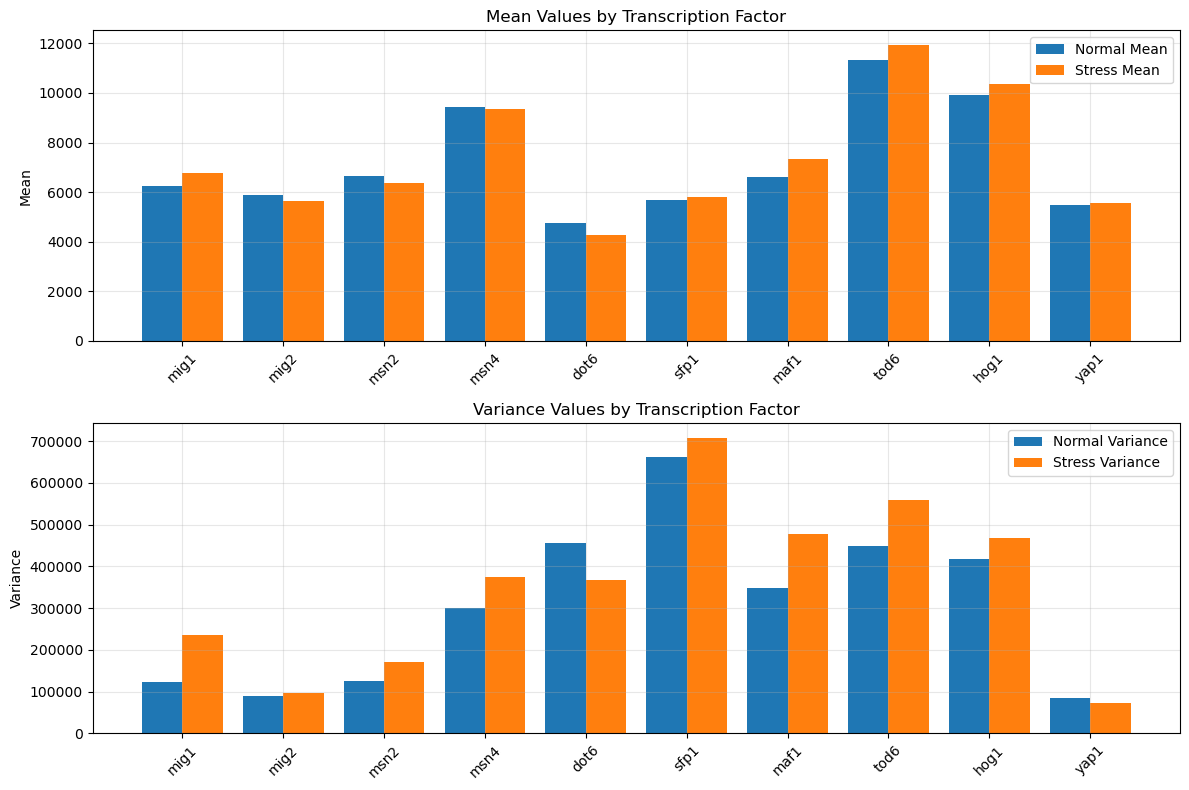

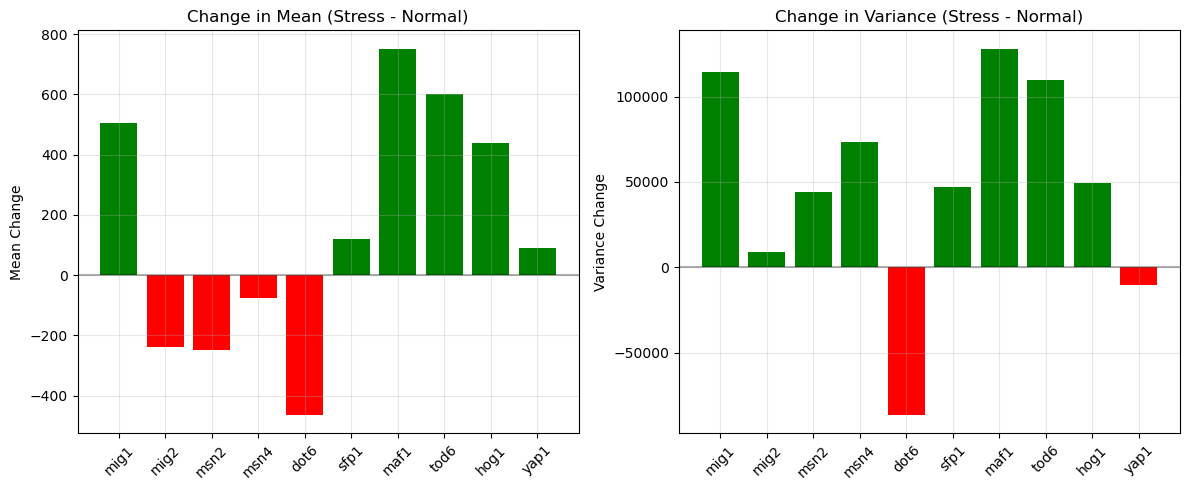

In [5]:
# Calculate and display time series statistics for each transcription factor
import pandas as pd
import numpy as np

# Create DataFrames to store statistics
mean_stats = pd.DataFrame(index=transcription_factors, 
                         columns=["Normal Mean", "Stress Mean", "Mean Change"])
var_stats = pd.DataFrame(index=transcription_factors, 
                        columns=["Normal Variance", "Stress Variance", "Variance Change"])

# Calculate mean and variance for each time series
for tf in transcription_factors:
    # Extract data for this transcription factor
    data = np.array(expts[tf][stress]["GFP"]["median"]).astype("float")
    t = np.array(expts[tf][stress]["general"]["times"]).astype("float")
    
    # Split into normal and stress conditions
    normal_data = data[:, t[0, :] < 0]
    stress_data = data[:, t[0, :] >= 0]
    
    # Calculate statistics for each cell over time
    cell_normal_means = np.nanmean(normal_data, axis=1)  # Mean for each cell
    cell_normal_vars = np.nanvar(normal_data, axis=1)    # Variance for each cell
    cell_stress_means = np.nanmean(stress_data, axis=1)  # Mean for each cell
    cell_stress_vars = np.nanvar(stress_data, axis=1)    # Variance for each cell
    
    # Calculate population statistics (across all cells)
    normal_mean = np.nanmean(cell_normal_means)
    normal_var = np.nanmean(cell_normal_vars)
    stress_mean = np.nanmean(cell_stress_means)
    stress_var = np.nanmean(cell_stress_vars)
    
    # Store in DataFrames
    mean_stats.loc[tf] = [normal_mean, stress_mean, stress_mean - normal_mean]
    var_stats.loc[tf] = [normal_var, stress_var, stress_var - normal_var]

# Display statistics
print("Mean Statistics for Each Transcription Factor:")
display(mean_stats)

print("\nVariance Statistics for Each Transcription Factor:")
display(var_stats)

# Create a visualization of the statistics
plt.figure(figsize=(12, 8))

# Plot means
plt.subplot(2, 1, 1)
plt.bar(np.arange(len(transcription_factors)) - 0.2, mean_stats["Normal Mean"], width=0.4, label="Normal Mean")
plt.bar(np.arange(len(transcription_factors)) + 0.2, mean_stats["Stress Mean"], width=0.4, label="Stress Mean")
plt.xticks(np.arange(len(transcription_factors)), transcription_factors, rotation=45)
plt.title("Mean Values by Transcription Factor")
plt.ylabel("Mean")
plt.legend()
plt.grid(alpha=0.3)

# Plot variances
plt.subplot(2, 1, 2)
plt.bar(np.arange(len(transcription_factors)) - 0.2, var_stats["Normal Variance"], width=0.4, label="Normal Variance")
plt.bar(np.arange(len(transcription_factors)) + 0.2, var_stats["Stress Variance"], width=0.4, label="Stress Variance")
plt.xticks(np.arange(len(transcription_factors)), transcription_factors, rotation=45)
plt.title("Variance Values by Transcription Factor")
plt.ylabel("Variance")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Plot the changes
plt.figure(figsize=(12, 5))

# Plot mean changes
plt.subplot(1, 2, 1)
colors = ['green' if x >= 0 else 'red' for x in mean_stats["Mean Change"]]
plt.bar(np.arange(len(transcription_factors)), mean_stats["Mean Change"], color=colors)
plt.xticks(np.arange(len(transcription_factors)), transcription_factors, rotation=45)
plt.title("Change in Mean (Stress - Normal)")
plt.ylabel("Mean Change")
plt.grid(alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Plot variance changes
plt.subplot(1, 2, 2)
colors = ['green' if x >= 0 else 'red' for x in var_stats["Variance Change"]]
plt.bar(np.arange(len(transcription_factors)), var_stats["Variance Change"], color=colors)
plt.xticks(np.arange(len(transcription_factors)), transcription_factors, rotation=45)
plt.title("Change in Variance (Stress - Normal)")
plt.ylabel("Variance Change")
plt.grid(alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

## Coefficient of Variation, Fano Factor

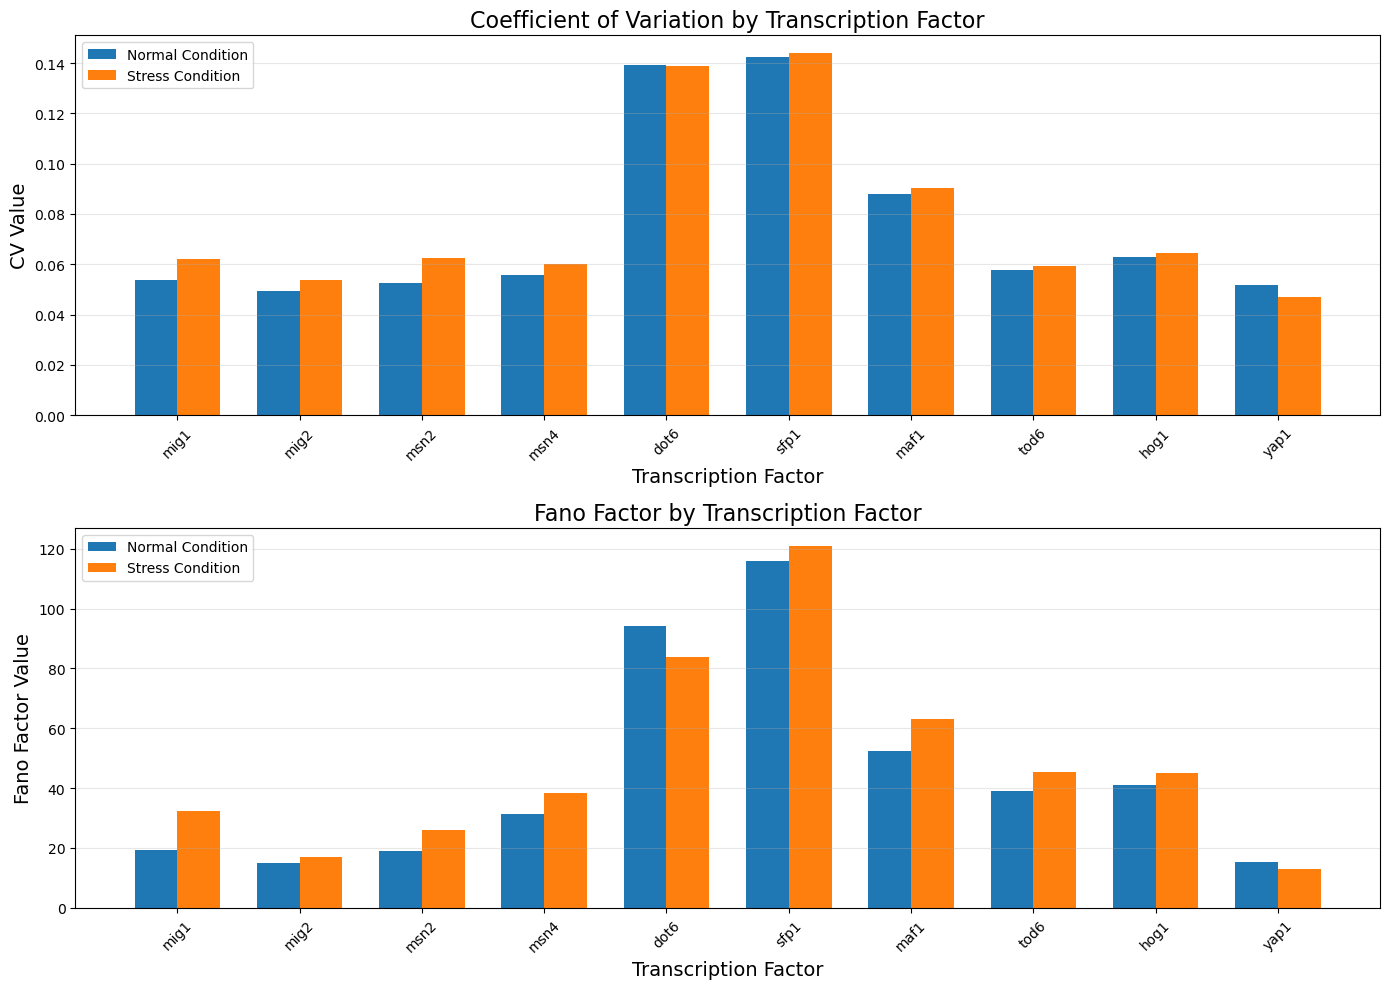

,TF,Normal CV,Stress CV,CV Change,Normal Fano,Stress Fano,Fano Change
0,mig1,0.053963,0.062031,0.008068,19.285650,32.262705,12.977056
1,mig2,0.049471,0.053691,0.004220,14.983168,17.113380,2.130212
2,msn2,0.052384,0.062496,0.010112,18.907963,26.147120,7.239157
3,msn4,0.055727,0.060238,0.004511,31.305620,38.372415,7.066795
4,dot6,0.139362,0.138816,-0.000546,94.373112,83.959267,-10.413845
5,sfp1,0.142419,0.143817,0.001398,115.852978,120.977369,5.124391
6,maf1,0.088105,0.090450,0.002345,52.296536,63.092357,10.795821
7,tod6,0.057681,0.059445,0.001765,39.100207,45.316700,6.216493
8,hog1,0.062891,0.064673,0.001782,41.164105,44.933858,3.769753
9,yap1,0.051674,0.047114,-0.004560,15.168945,13.029128,-2.139817


In [6]:
from utils.fano_factor import calculate_fano_factor
from utils.cv import calculate_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dictionary to store CV and Fano factor for all transcription factors
cv_fano_summary = {}

# Process data for all transcription factors
for transcription_factor in transcription_factors:
    # Extract data for this transcription factor
    data = np.array(expts[transcription_factor][stress]["GFP"]["median"]).astype("float")
    t = np.array(expts[transcription_factor][stress]["general"]["times"]).astype("float")
    
    # Split into normal and stress conditions
    normal_data = data[:, t[0, :] < 0]
    stress_data = data[:, t[0, :] >= 0]
    
    # Calculate mean and variance for each cell
    normal_means = np.nanmean(normal_data, axis=1)
    normal_variances = np.nanvar(normal_data, axis=1)
    stress_means = np.nanmean(stress_data, axis=1)
    stress_variances = np.nanvar(stress_data, axis=1)
    
    # Calculate CV for each cell and take average using the correct function signature
    normal_cv = np.mean([calculate_cv(normal_variances[j], normal_means[j]) for j in range(normal_data.shape[0])])
    stress_cv = np.mean([calculate_cv(stress_variances[j], stress_means[j]) for j in range(stress_data.shape[0])])
    
    # Calculate Fano factor for each cell and take average using the correct function signature
    normal_fano = np.mean([calculate_fano_factor(normal_variances[j], normal_means[j]) for j in range(normal_data.shape[0])])
    stress_fano = np.mean([calculate_fano_factor(stress_variances[j], stress_means[j]) for j in range(stress_data.shape[0])])
    
    # Store in summary dictionary
    cv_fano_summary[transcription_factor] = {
        "normal": {"cv": normal_cv, "fano": normal_fano},
        "stress": {"cv": stress_cv, "fano": stress_fano}
    }
    
# Create two separate plots for CV and Fano factor
plt.figure(figsize=(14, 10))

# Plot 1: Coefficient of Variation
plt.subplot(2, 1, 1)
x = np.arange(len(transcription_factors))
width = 0.35

# Plot CV values
plt.bar(x - width/2, [cv_fano_summary[tf]["normal"]["cv"] for tf in transcription_factors], 
        width, label='Normal Condition')
plt.bar(x + width/2, [cv_fano_summary[tf]["stress"]["cv"] for tf in transcription_factors], 
        width, label='Stress Condition')

# Add labels and formatting
plt.title('Coefficient of Variation by Transcription Factor', fontsize=16)
plt.xlabel('Transcription Factor', fontsize=14)
plt.ylabel('CV Value', fontsize=14)
plt.xticks(x, transcription_factors, rotation=45)
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.3)

# Plot 2: Fano Factor
plt.subplot(2, 1, 2)

# Plot Fano factor values
plt.bar(x - width/2, [cv_fano_summary[tf]["normal"]["fano"] for tf in transcription_factors], 
        width, label='Normal Condition')
plt.bar(x + width/2, [cv_fano_summary[tf]["stress"]["fano"] for tf in transcription_factors], 
        width, label='Stress Condition')

# Add labels and formatting
plt.title('Fano Factor by Transcription Factor', fontsize=16)
plt.xlabel('Transcription Factor', fontsize=14)
plt.ylabel('Fano Factor Value', fontsize=14)
plt.xticks(x, transcription_factors, rotation=45)
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Create a summary table for all transcription factors
data_for_df = []
for tf in transcription_factors:
    data_for_df.append({
        "TF": tf,
        "Normal CV": cv_fano_summary[tf]["normal"]["cv"],
        "Stress CV": cv_fano_summary[tf]["stress"]["cv"],
        "CV Change": cv_fano_summary[tf]["stress"]["cv"] - cv_fano_summary[tf]["normal"]["cv"],
        "Normal Fano": cv_fano_summary[tf]["normal"]["fano"],
        "Stress Fano": cv_fano_summary[tf]["stress"]["fano"],
        "Fano Change": cv_fano_summary[tf]["stress"]["fano"] - cv_fano_summary[tf]["normal"]["fano"]
    })

# Create DataFrame and display
summary_df = pd.DataFrame(data_for_df)
display(summary_df)

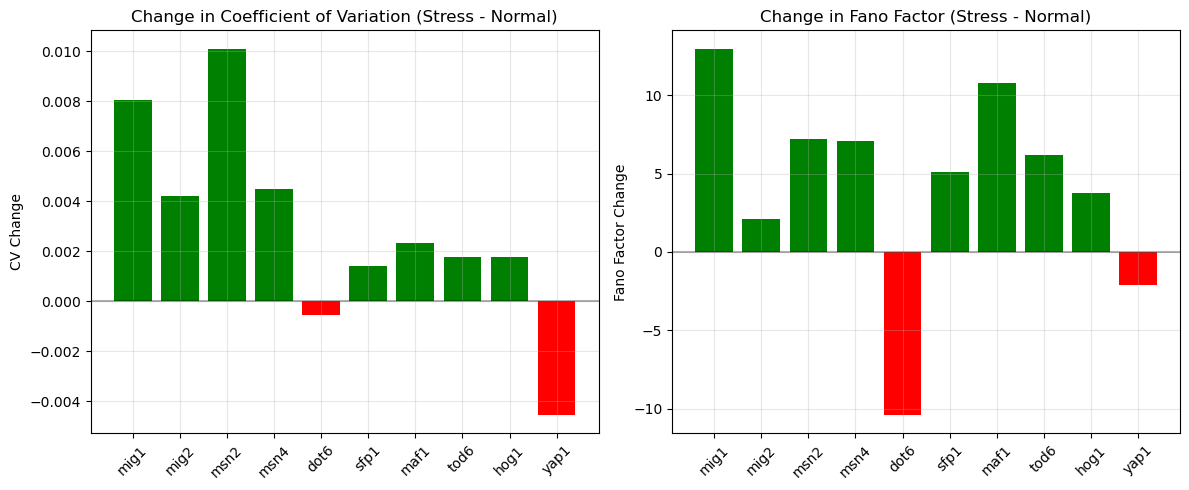

In [7]:
# Plot changes in CV and Fano factor
plt.figure(figsize=(12, 5))

# Extract CV and Fano factor changes from the summary DataFrame
cv_changes = summary_df["CV Change"].values
fano_changes = summary_df["Fano Change"].values

# Plot CV changes
plt.subplot(1, 2, 1)
colors = ['green' if x >= 0 else 'red' for x in cv_changes]
plt.bar(np.arange(len(transcription_factors)), cv_changes, color=colors)
plt.xticks(np.arange(len(transcription_factors)), transcription_factors, rotation=45)
plt.title("Change in Coefficient of Variation (Stress - Normal)")
plt.ylabel("CV Change")
plt.grid(alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Plot Fano factor changes
plt.subplot(1, 2, 2)
colors = ['green' if x >= 0 else 'red' for x in fano_changes]
plt.bar(np.arange(len(transcription_factors)), fano_changes, color=colors)
plt.xticks(np.arange(len(transcription_factors)), transcription_factors, rotation=45)
plt.title("Change in Fano Factor (Stress - Normal)")
plt.ylabel("Fano Factor Change")
plt.grid(alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()



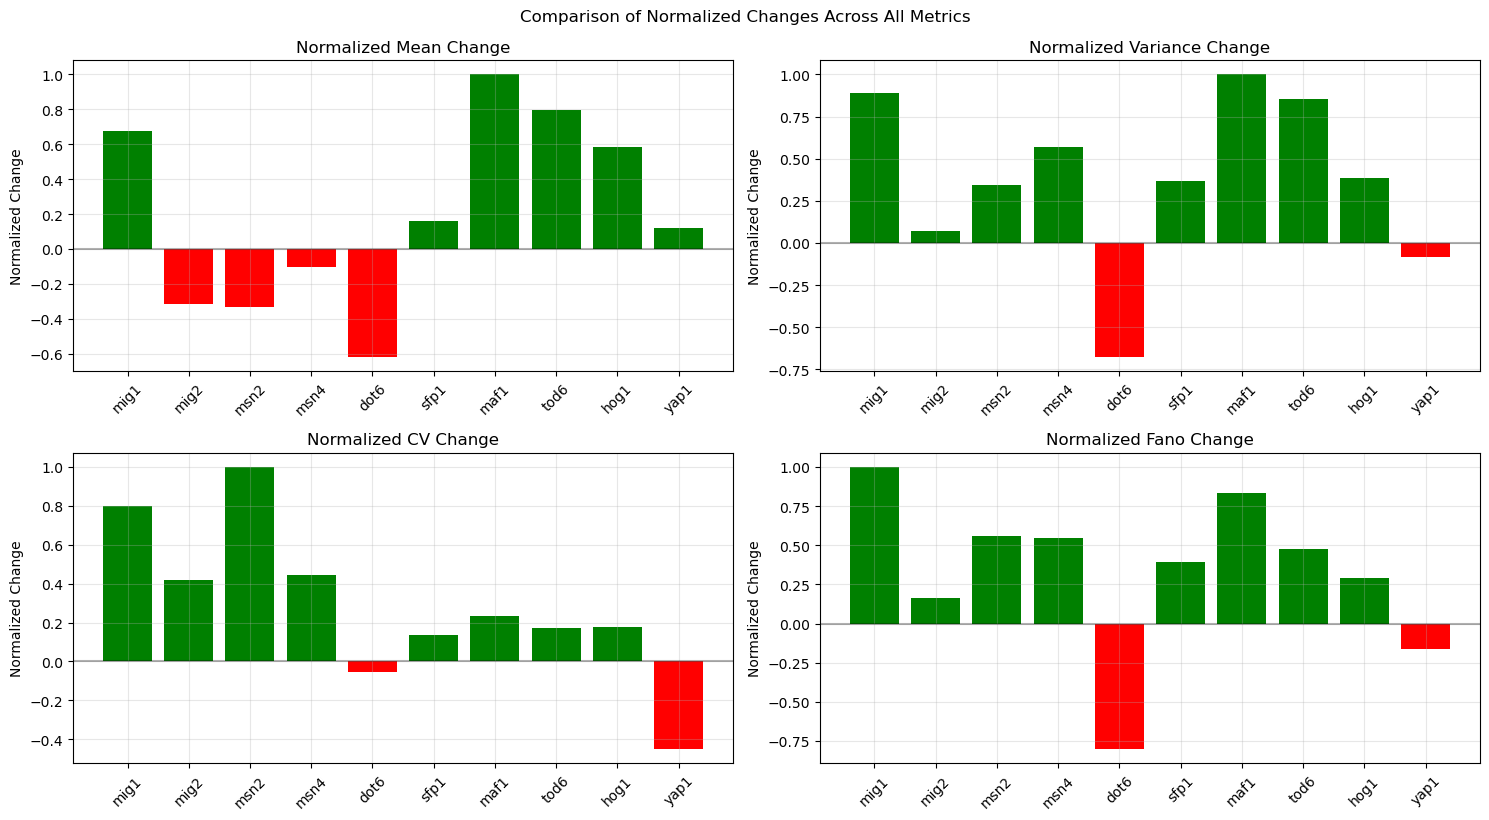

In [8]:
# Additional visualization: Compare all four metrics side by side
plt.figure(figsize=(15, 8))
metrics = ["Mean Change", "Variance Change", "CV Change", "Fano Change"]
data = [
    mean_stats["Mean Change"].values,
    var_stats["Variance Change"].values,
    summary_df["CV Change"].values,
    summary_df["Fano Change"].values
]

# Normalize each metric to enable comparison on the same scale
normalized_data = []
for metric_data in data:
    if np.max(np.abs(metric_data)) > 0:  # Avoid division by zero
        normalized_data.append(metric_data / np.max(np.abs(metric_data)))
    else:
        normalized_data.append(metric_data)

# Plot all normalized metrics together
for i, (metric, values) in enumerate(zip(metrics, normalized_data)):
    plt.subplot(2, 2, i+1)
    colors = ['green' if x >= 0 else 'red' for x in values]
    plt.bar(np.arange(len(transcription_factors)), values, color=colors)
    plt.xticks(np.arange(len(transcription_factors)), transcription_factors, rotation=45)
    plt.title(f"Normalized {metric}")
    plt.ylabel("Normalized Change")
    plt.grid(alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.suptitle("Comparison of Normalized Changes Across All Metrics", y=1.02)
plt.show()

Top 3 TFs with highest CV change (magnitude):
msn2: 0.1519
dot6: 0.1480
msn4: 0.0837

Top 3 TFs with highest Fano factor change (magnitude):
msn2: 0.1062
dot6: 0.0980
msn4: 0.0227


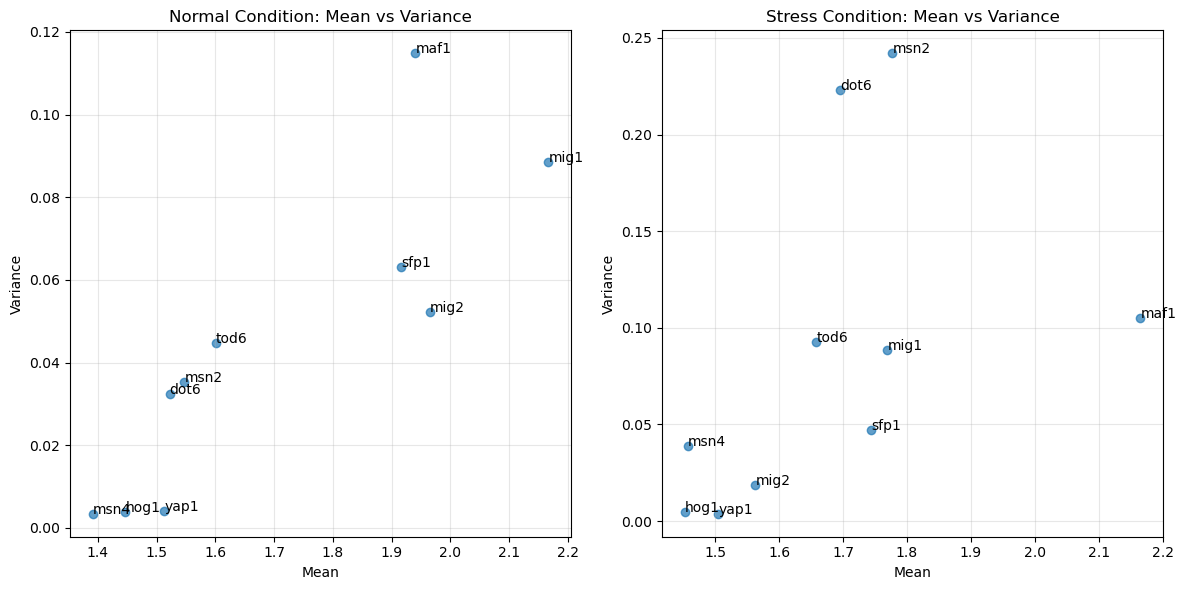


Correlation between CV and Fano factor:
Normal condition: 0.9828
Stress condition: 0.9696

TFs with consistent changes across both CV and Fano factor: 10/10
mig1, mig2, msn2, msn4, dot6, sfp1, maf1, tod6, hog1, yap1


In [14]:
# Summary of findings

# Find transcription factors with highest change in variability metrics
cv_changes = [(tf, cv_fano_summary[tf]['stress']['cv'] - cv_fano_summary[tf]['normal']['cv']) 
             for tf in transcription_factors]
fano_changes = [(tf, cv_fano_summary[tf]['stress']['fano'] - cv_fano_summary[tf]['normal']['fano']) 
                for tf in transcription_factors]

# Sort by magnitude of change
cv_changes.sort(key=lambda x: abs(x[1]), reverse=True)
fano_changes.sort(key=lambda x: abs(x[1]), reverse=True)

# Display top 3 TFs with highest CV and Fano factor changes
print("Top 3 TFs with highest CV change (magnitude):")
for i in range(min(3, len(cv_changes))):
    print(f"{cv_changes[i][0]}: {cv_changes[i][1]:.4f}")
    
print("\nTop 3 TFs with highest Fano factor change (magnitude):")
for i in range(min(3, len(fano_changes))):
    print(f"{fano_changes[i][0]}: {fano_changes[i][1]:.4f}")

# Analyse correlation between mean and variance across TFs
means_normal = [stats_summary[tf]['normal']['mean'] for tf in transcription_factors]
vars_normal = [stats_summary[tf]['normal']['variance'] for tf in transcription_factors]
means_stress = [stats_summary[tf]['stress']['mean'] for tf in transcription_factors]
vars_stress = [stats_summary[tf]['stress']['variance'] for tf in transcription_factors]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(means_normal, vars_normal, alpha=0.7)
for i, tf in enumerate(transcription_factors):
    plt.annotate(tf, (means_normal[i], vars_normal[i]))
plt.title("Normal Condition: Mean vs Variance")
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(means_stress, vars_stress, alpha=0.7)
for i, tf in enumerate(transcription_factors):
    plt.annotate(tf, (means_stress[i], vars_stress[i]))
plt.title("Stress Condition: Mean vs Variance")
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation between CV and Fano factor
cvs_normal = [cv_fano_summary[tf]['normal']['cv'] for tf in transcription_factors]
fanos_normal = [cv_fano_summary[tf]['normal']['fano'] for tf in transcription_factors]
cvs_stress = [cv_fano_summary[tf]['stress']['cv'] for tf in transcription_factors]
fanos_stress = [cv_fano_summary[tf]['stress']['fano'] for tf in transcription_factors]

corr_normal = np.corrcoef(cvs_normal, fanos_normal)[0, 1]
corr_stress = np.corrcoef(cvs_stress, fanos_stress)[0, 1]

print(f"\nCorrelation between CV and Fano factor:")
print(f"Normal condition: {corr_normal:.4f}")
print(f"Stress condition: {corr_stress:.4f}")

# Analyze which TFs show consistent behavior across metrics
consistent_tfs = []
for tf in transcription_factors:
    cv_change = cv_fano_summary[tf]['stress']['cv'] - cv_fano_summary[tf]['normal']['cv']
    fano_change = cv_fano_summary[tf]['stress']['fano'] - cv_fano_summary[tf]['normal']['fano']
    
    # Check if both metrics change in the same direction
    if (cv_change > 0 and fano_change > 0) or (cv_change < 0 and fano_change < 0):
        consistent_tfs.append(tf)

print(f"\nTFs with consistent changes across both CV and Fano factor: {len(consistent_tfs)}/{len(transcription_factors)}")
print(", ".join(consistent_tfs))